# **Note**
This script deconvolve the original training images into different color images, including RGB, hematoxylin and eosin images.

In [1]:
# Mount this script to my drive
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/2022_趨勢_機器學習比賽/OBJ_Train_Datasets/')

Mounted at /content/drive


# ** Read Packages **
⚫ histomicstk: Allow us to do color deconvolution.

In [ ]:
%pip install histomicstk --find-links https://girder.github.io/large_image_wheels
%pip uninstall opencv-python-headless
%pip install opencv-python-headless==4.1.2.30

In [5]:
# For hematoxylin and eosin color deconvolution.
import histomicstk as htk

# Others
import cv2
import numpy as np
import skimage.color
import skimage.io
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random

# ** Create function for reading the data **

In [6]:
# Read the dataset and return the image as a 3D array and a dictionary contains 
# all important information listed in the annotation files.
# Be aware that 
# (1) the color order of the img array is BGR if you use cv2.imread.
# (2) the dimensions of the image are ordered in (y,x,color).

def Read(img_num,read_img=True):
  img_file=f'./Train_Images/{img_num}.jpg'
  ann_file=f'./Train_Annotations/{img_num}.xml'
  tree = ET.parse(ann_file)
  root = tree.getroot()
  inf_dict={}
  count=0

  for obj in root.findall('object'):
    xmin=int(obj.find('bndbox').find('xmin').text)
    ymin=int(obj.find('bndbox').find('ymin').text)
    xmax=int(obj.find('bndbox').find('xmax').text)
    ymax=int(obj.find('bndbox').find('ymax').text)
    inf_dict[count]=[(xmin,ymin),(xmax,ymax)]
    count+=1

  inf_dict['STAS_num']=count
  inf_dict['xsize']=root.find('size').find('width').text
  inf_dict['ysize']=root.find('size').find('height').text
  inf_dict['zsize']=root.find('size').find('depth').text

  if read_img:
    img=cv2.imread(img_file)
    return img, inf_dict
  else:
    return inf_dict

# **Hematoxylin and the eosin color deconvolution**

In [ ]:
# Plot the images deconvloved by the hematoxylin and the eosin and save the
# figures. Reference for the package histomicstk: 
# https://digitalslidearchive.github.io/HistomicsTK/examples/color_deconvolution.html

# Set up for the plotting
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi']=150
titlesize = 24

# Set up for the image numbers
img_num_list=[f'{i:08}' for i in range(1053)] # We have 1053 training images
# random.shuffle(img_num_list)


for img_num in img_num_list: 
  print(f'Dealing with image {img_num} now....')
  img_file=f'./Train_Images/{img_num}.jpg'
  imInput = skimage.io.imread(img_file)[:, :, :3]
  stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map

  # specify stains of input image
  stains = ['hematoxylin',  # nuclei stain
            'eosin',        # cytoplasm stain
            'null']         # set to null if input contains only two stains

  W = np.array([stain_color_map[st] for st in stains]).T
  imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, W)


  #Save the figures (or plot the figures with other desired features in the next blocks
  cv2.imwrite(f'./Train_images_hematoxylin/{img_num}.jpg',imDeconvolved.Stains[:, :, 0],[cv2.IMWRITE_JPEG_QUALITY, 70])
  cv2.imwrite(f'./Train_images_eosin/{img_num}.jpg',imDeconvolved.Stains[:, :, 1],  [cv2.IMWRITE_JPEG_QUALITY, 70])
  
  # Plot the figures with other desired features
  # hematoxylin
  # fig = plt.figure()
  # fig.subplots_adjust(bottom=0.,left=0.,right=1.,top=1.)
  # plt.imshow(imDeconvolved.Stains[:, :, 0],cmap='gray')
  # plt.title(stains[0])
  # plt.axis('off')
  # plt.savefig(f'./Train_images_hematoxylin/{img_num}.jpg',bbox_inches='tight')
  # plt.close()
  # eosin
  # plt.figure()
  # plt.imshow(imDeconvolved.Stains[:, :, 1],cmap='gray')
  # plt.title(stains[1])
  # plt.axis('off')
  # plt.savefig(f'./Train_images_eosin/{img_num}.jpg',bbox_inches='tight')
  # plt.close();

# print('stain_color_map:', stain_color_map, sep='\n');

# ** RGB color deconvolution**

In [ ]:
# Read the images, extract the RGB colors images and save them.

# Set up for the plotting
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi']=150
titlesize = 24

# Set up for the image numbers
img_num_list=[f'{i:08}' for i in range(1053)] # We have 1053 training images
random.shuffle(img_num_list)

img_b_ravel=np.empty(1)
img_g_ravel=np.empty(1)
img_r_ravel=np.empty(1)
img_stas_b_ravel=np.empty(1)
img_stas_g_ravel=np.empty(1)
img_stas_r_ravel=np.empty(1)

# Only pick up 100 samples randomly or we would run out of memory 
# by storing the pixel values in each color images.

for img_num in img_num_list[:100]: 
  print(f'Dealing with image {img_num} now....')
  img,inf=Read(img_num)
  img_b=img[:,:,0]
  img_g=img[:,:,1]
  img_r=img[:,:,2]
  
  # img_b_ravel=np.append(img_b_ravel,img_b.ravel())
  # img_g_ravel=np.append(img_g_ravel,img_g.ravel())
  # img_r_ravel=np.append(img_r_ravel,img_r.ravel())

  for obj_num in range(inf['STAS_num']):
    x_ind1,x_ind2=inf[obj_num][0][0],inf[obj_num][1][0]
    y_ind1,y_ind2=inf[obj_num][0][1],inf[obj_num][1][1]
    img_stas_b_ravel=np.append(img_stas_b_ravel,img_b[y_ind1:y_ind2,x_ind1:x_ind2].ravel())
    img_stas_g_ravel=np.append(img_stas_g_ravel,img_g[y_ind1:y_ind2,x_ind1:x_ind2].ravel())
    img_stas_r_ravel=np.append(img_stas_r_ravel,img_r[y_ind1:y_ind2,x_ind1:x_ind2].ravel())
  
  # Save the red, blue and the green images
  plt.figure()
  plt.imshow(img_b,cmap='gray')
  plt.title('Blue')
  plt.axis('off')
  # plt.savefig(f'./Train_images_B/{img_num}.jpg',bbox_inches='tight')
  plt.close()
  plt.figure()
  plt.imshow(img_g,cmap='gray')
  plt.title('Green')
  plt.axis('off')
  # plt.savefig(f'./Train_images_G/{img_num}.jpg',bbox_inches='tight')
  plt.close()
  plt.figure()
  plt.imshow(img_r,cmap='gray')
  plt.title('Red')
  plt.axis('off')
  # plt.savefig(f'./Train_images_R/{img_num}.jpg',bbox_inches='tight')
  plt.close();

# ** Plot the RGB instensity distribution**
Just wanna see the distribution. Could influence how we normalize the data in preprocessing.

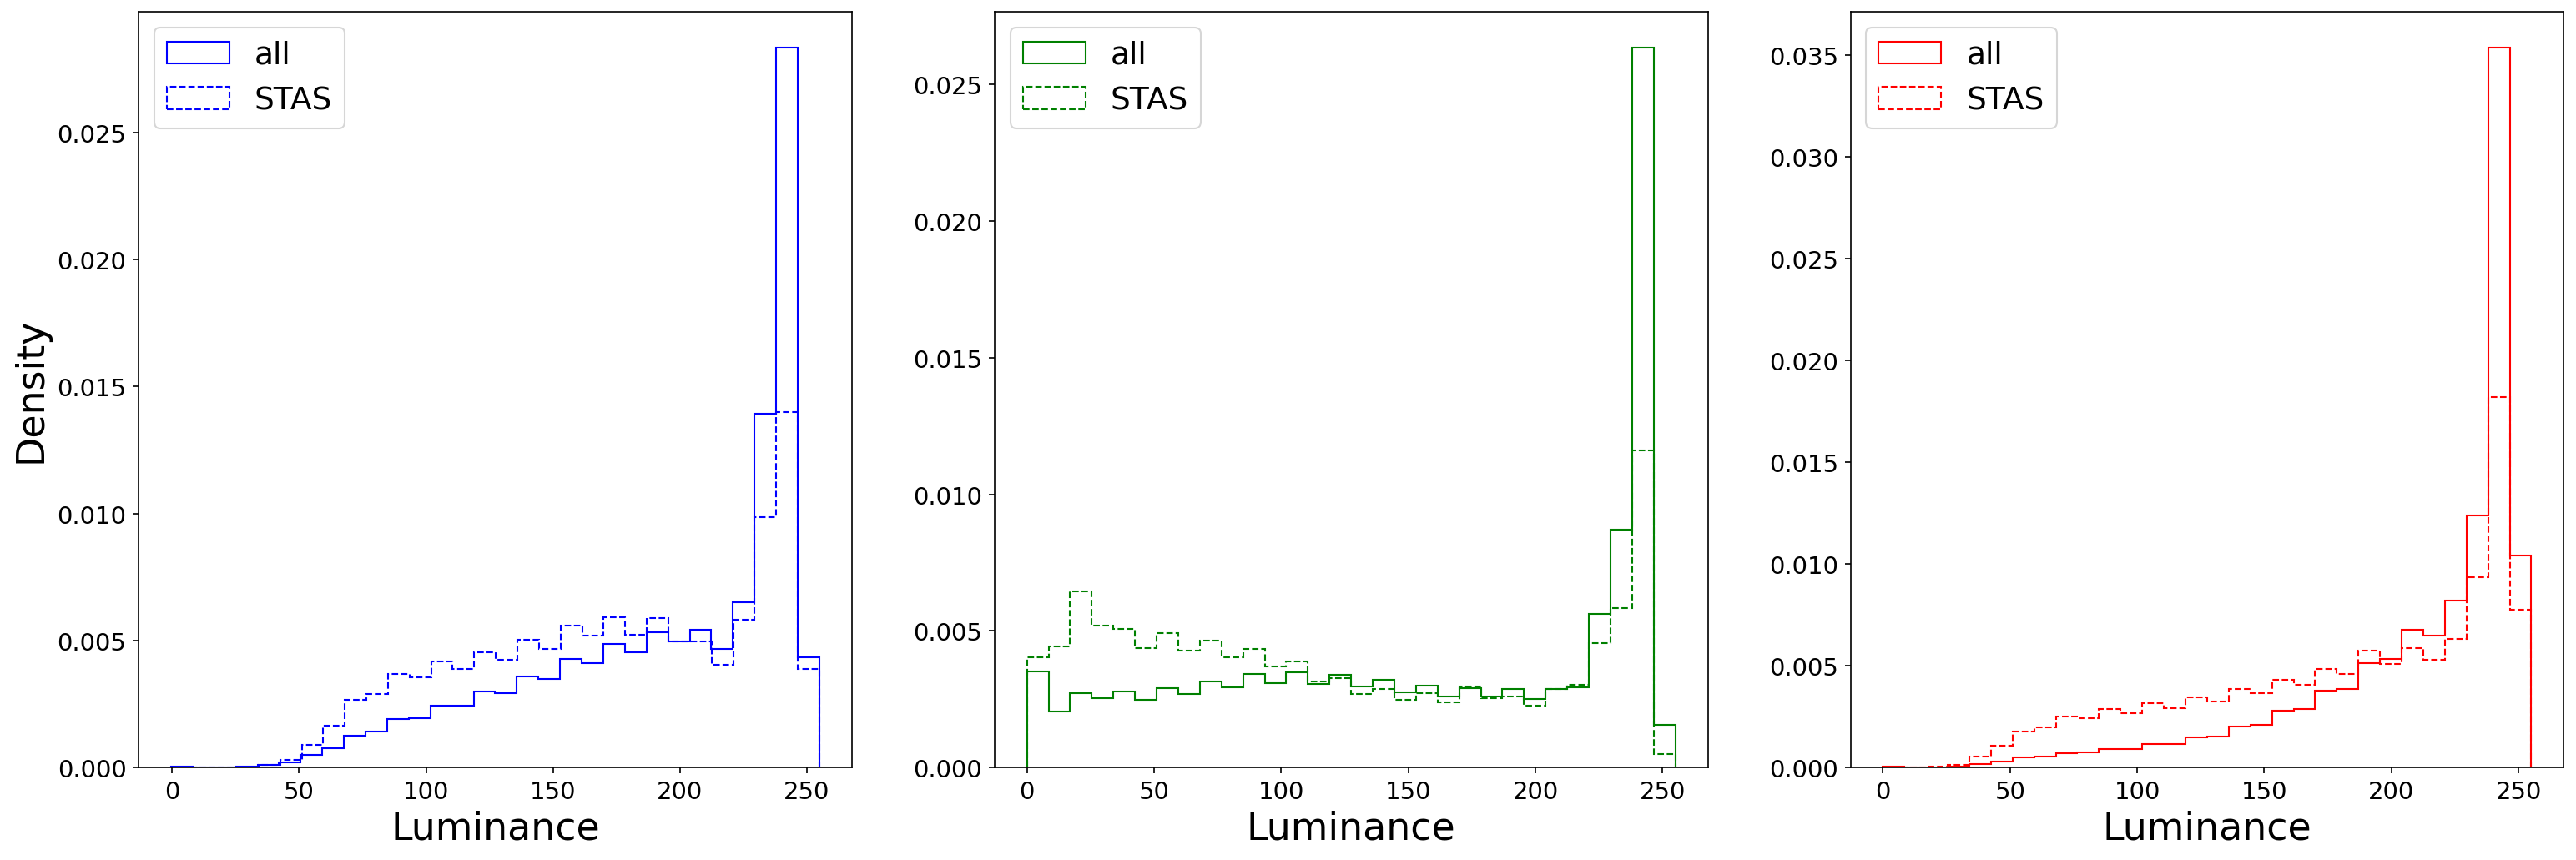

In [ ]:
# Plot the RGB instensity distribution of all pixels in our randomly 
# selected images
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.hist(img_b_ravel,color='blue',bins=30,histtype='step',density=True,label='all');
plt.hist(img_stas_b_ravel,color='blue',bins=30,histtype='step',linestyle='dashed',density=True,label='STAS');
plt.ylabel('Density',size=22)
plt.xlabel('Luminance',size=22)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc=2,prop={'size':18})
plt.subplot(132)
plt.hist(img_g_ravel,color='green',bins=30,histtype='step',density=True,label='all');
plt.hist(img_stas_g_ravel,color='green',bins=30,histtype='step',linestyle='dashed',density=True,label='STAS');
plt.xlabel('Luminance',size=22)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc=2,prop={'size':18})
plt.subplot(133)
plt.hist(img_r_ravel,color='red',bins=30,histtype='step',density=True,label='all');
plt.hist(img_stas_r_ravel,color='red',bins=30,histtype='step',linestyle='dashed',density=True,label='STAS');
plt.xlabel('Luminance',size=22)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc=2,prop={'size':18});
# plt.savefig('Statistics/Luminance_dist.jpg')
# plt.close()